In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
#from sklearn.model_selection import GridSearchCV
import itertools
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import NearMiss, OneSidedSelection
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

# Set random seed to ensure reproducible runs
RSEED = 50

In [29]:
data = pd.read_csv('ALL_CONCAT_CLIENTE_M_C.csv')
data = data.drop(columns=['time'])#,'ip_flags_resbit','ip_flags_morefrag','ip_frag_offset','tcp_flags_cong_window_reduced','tcp_flags_explicit_cong_notif','tcp_flags_urg_pointer'])

data['stalling_event'].value_counts()
model = RandomForestClassifier(n_estimators=100,
                              random_state = RSEED,
                              max_features = 'sqrt',
                              n_jobs=-1, verbose = 1)
#unbalanced

In [30]:
#extract labels
X = data.drop(['stalling_event'], axis=1)
y = data['stalling_event']

#30% examples in test data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                          stratify = y,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

features = list(X_train.columns)
#For column importance

In [31]:
class_weight = {}
class_weight = compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

#clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=RSEED, verbose=1, max_features='sqrt', class_weight=dict(enumerate(class_weights)))

model = CatBoostClassifier(n_estimators=100, random_state=RSEED, verbose=0, class_weights=class_weight)#, max_features='sqrt', class_weight=dict(enumerate(class_weights)))

scorings=['f1','recall']
cv = cross_validate(model, X_train, y_train, cv=5, scoring=scorings)#'f1')#make_scorer(f1_score, average=None))
print ("F1-Score using RF with 5 cross validation : " + str(np.mean(cv['test_f1'])))
print ("Recall using RF with 5 cross validation : " + str(np.mean(cv['test_recall'])))

model.fit(X_train, y_train)    
y_predict_test = model.predict(X_test)

#F1_score

score_test =f1_score(y_test, y_predict_test, average = None)

print (score_test)
print(classification_report(y_test, y_predict_test))

F1-Score using RF with 5 cross validation : 0.5720243537011402
Recall using RF with 5 cross validation : 0.866485636799929
[0.89749229 0.57425098]
              precision    recall  f1-score   support

           0       0.98      0.83      0.90    193153
           1       0.43      0.87      0.57     28559

    accuracy                           0.83    221712
   macro avg       0.70      0.85      0.74    221712
weighted avg       0.91      0.83      0.86    221712



In [32]:
train_rf_predictions = model.predict(X_train)
train_rf_probs = model.predict_proba(X_train)[:, 1]

rf_predictions = model.predict(X_test) #!!
rf_probs = model.predict_proba(X_test)[:, 1]

In [33]:
fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model

NameError: name 'features' is not defined

In [34]:
from sklearn.metrics import classification_report

print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90    193153
           1       0.43      0.87      0.57     28559

    accuracy                           0.83    221712
   macro avg       0.70      0.85      0.74    221712
weighted avg       0.91      0.83      0.86    221712



In [35]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');


Recall Baseline: 1.0 Test: 0.87 Train: 0.86
Precision Baseline: 0.13 Test: 0.43 Train: 0.43
Roc Baseline: 0.5 Test: 0.93 Train: 0.93


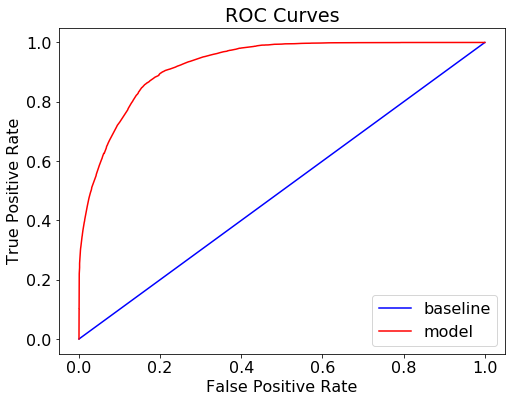

In [36]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

In [37]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[160372  32781]
 [  3853  24706]]


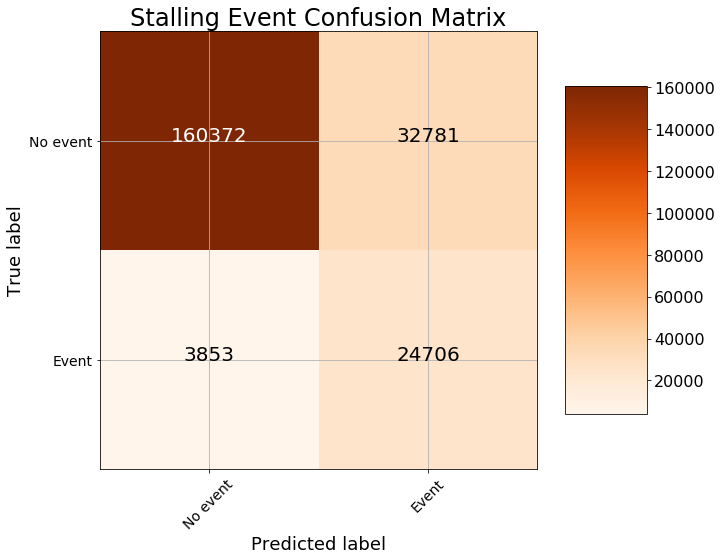

In [38]:
cm = confusion_matrix(y_test, rf_predictions)
plot_confusion_matrix(cm, classes = ['No event', 'Event'],
                      title = 'Stalling Event Confusion Matrix')